In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0336 - acc: 0.3658
Epoch 00001: val_loss improved from inf to 1.64171, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_3_conv_checkpoint/001-1.6417.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.0336 - acc: 0.3658 - val_loss: 1.6417 - val_acc: 0.4915
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4254 - acc: 0.5569
Epoch 00002: val_loss improved from 1.64171 to 1.46824, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_3_conv_checkpoint/002-1.4682.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.4255 - acc: 0.5569 - val_loss: 1.4682 - val_acc: 0.5323
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1987 - acc: 0.6301
Epoch 00003: val_loss improved from 1.46824 to 1.4273

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0862 - acc: 0.9794
Epoch 00028: val_loss did not improve from 1.35805
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0863 - acc: 0.9794 - val_loss: 1.9797 - val_acc: 0.6310
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9780
Epoch 00029: val_loss did not improve from 1.35805
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0915 - acc: 0.9780 - val_loss: 2.0243 - val_acc: 0.6322
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0816 - acc: 0.9804
Epoch 00030: val_loss did not improve from 1.35805
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0816 - acc: 0.9804 - val_loss: 2.1325 - val_acc: 0.6173
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0799 - acc: 0.9814
Epoch 00031: val_loss did not improve from 1.35805
36805/36805 [===========

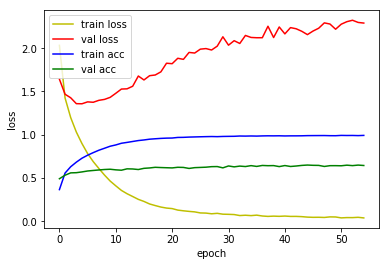

4815/4815 [==============================] - 2s 449us/sample - loss: 1.4146 - acc: 0.5499
Loss: 1.4145817289223677 Accuracy: 0.5499481

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9694 - acc: 0.3770
Epoch 00001: val_loss improved from inf to 1.52738, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_4_conv_checkpoint/001-1.5274.hdf5
36805/36805 [==============================] - 35s 940us/sample - loss: 1.9693 - acc: 0.3770 - val_loss: 1.5274 - val_acc: 0.5211
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4023 - acc: 0.5630
Epoch 00002: val_loss improved from 1.52738 to 1.34616, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_4_conv_checkpoint/002-1.3462.hdf5
36805/36805 [==============================] - 33s 892us/sample - loss: 1.4023 - acc: 0.5630 - val_loss: 1.3462 - val_acc: 0.5837
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9659
Epoch 00027: val_loss did not improve from 1.11597
36805/36805 [==============================] - 33s 889us/sample - loss: 0.1183 - acc: 0.9659 - val_loss: 1.4181 - val_acc: 0.7084
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9677
Epoch 00028: val_loss did not improve from 1.11597
36805/36805 [==============================] - 33s 888us/sample - loss: 0.1108 - acc: 0.9676 - val_loss: 1.4198 - val_acc: 0.7128
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9664
Epoch 00029: val_loss did not improve from 1.11597
36805/36805 [==============================] - 33s 885us/sample - loss: 0.1138 - acc: 0.9664 - val_loss: 1.4259 - val_acc: 0.7144
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9716
Epoch 00030: val_loss did not improve from 1.11597
36805/36805 [==================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9889
Epoch 00057: val_loss did not improve from 1.11597
36805/36805 [==============================] - 33s 888us/sample - loss: 0.0442 - acc: 0.9889 - val_loss: 1.5859 - val_acc: 0.7405

1D_CNN_custom_multi_3_concat_DO_4_conv Model


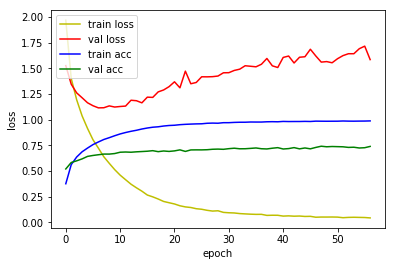

4815/4815 [==============================] - 2s 413us/sample - loss: 1.1846 - acc: 0.6318
Loss: 1.1846418001941432 Accuracy: 0.6317757

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9855 - acc: 0.3670
Epoch 00001: val_loss improved from inf to 1.49204, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_5_conv_checkpoint/001-1.4920.hdf5
36805/36805 [==============================] - 34s 916us/sample - loss: 1.9854 - acc: 0.3670 - val_loss: 1.4920 - val_acc: 0.5260
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3997 - acc: 0.5687
Epoch 00002: val_loss improved from 1.49204 to 1.27015, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_5_conv_checkpoint/002-1.2702.hdf5
36805/36805 [==============================] - 32s 867us/sample - loss: 1.3997 - acc: 0.5687 - val_loss: 1.2702 - val_acc: 0.6075
Epoch 3/500
36800/36805 [============================>.] 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1911 - acc: 0.9417
Epoch 00025: val_loss did not improve from 0.71459
36805/36805 [==============================] - 32s 863us/sample - loss: 0.1911 - acc: 0.9417 - val_loss: 0.7217 - val_acc: 0.8181
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1761 - acc: 0.9465
Epoch 00026: val_loss did not improve from 0.71459
36805/36805 [==============================] - 32s 860us/sample - loss: 0.1761 - acc: 0.9465 - val_loss: 0.7640 - val_acc: 0.8032
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9496
Epoch 00027: val_loss did not improve from 0.71459
36805/36805 [==============================] - 32s 858us/sample - loss: 0.1638 - acc: 0.9496 - val_loss: 0.7623 - val_acc: 0.8120
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9507
Epoch 00028: val_loss did not improve from 0.71459
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9832
Epoch 00055: val_loss did not improve from 0.71459
36805/36805 [==============================] - 32s 861us/sample - loss: 0.0596 - acc: 0.9832 - val_loss: 0.8144 - val_acc: 0.8393
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9853
Epoch 00056: val_loss did not improve from 0.71459
36805/36805 [==============================] - 31s 855us/sample - loss: 0.0542 - acc: 0.9853 - val_loss: 0.8586 - val_acc: 0.8337
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9848
Epoch 00057: val_loss did not improve from 0.71459
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0546 - acc: 0.9848 - val_loss: 0.8257 - val_acc: 0.8439
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9847
Epoch 00058: val_loss did not improve from 0.71459
36805/36805 [=====

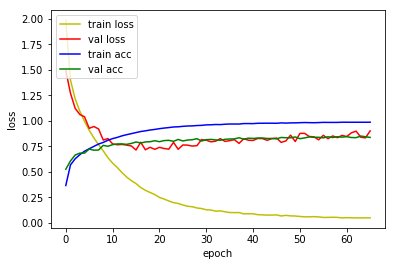

4815/4815 [==============================] - 2s 440us/sample - loss: 0.8217 - acc: 0.7626
Loss: 0.8217454534082026 Accuracy: 0.7626168

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0351 - acc: 0.3443
Epoch 00001: val_loss improved from inf to 1.51962, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_6_conv_checkpoint/001-1.5196.hdf5
36805/36805 [==============================] - 35s 946us/sample - loss: 2.0350 - acc: 0.3443 - val_loss: 1.5196 - val_acc: 0.5278
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4453 - acc: 0.5493
Epoch 00002: val_loss improved from 1.51962 to 1.25396, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_6_conv_checkpoint/002-1.2540.hdf5
36805/36805 [==============================] - 32s 865us/sample - loss: 1.4454 - acc: 0.5493 - val_loss: 1.2540 - val_acc: 0.6240
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2431 - acc: 0.9225
Epoch 00023: val_loss improved from 0.32533 to 0.31005, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_6_conv_checkpoint/023-0.3100.hdf5
36805/36805 [==============================] - 32s 859us/sample - loss: 0.2430 - acc: 0.9225 - val_loss: 0.3100 - val_acc: 0.9129
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2283 - acc: 0.9291
Epoch 00024: val_loss did not improve from 0.31005
36805/36805 [==============================] - 32s 857us/sample - loss: 0.2283 - acc: 0.9291 - val_loss: 0.3240 - val_acc: 0.9054
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9311
Epoch 00025: val_loss did not improve from 0.31005
36805/36805 [==============================] - 32s 862us/sample - loss: 0.2177 - acc: 0.9311 - val_loss: 0.3396 - val_acc: 0.9061
Epoch 26/500
36800/36805 [============================>.] - ET

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9776
Epoch 00051: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 862us/sample - loss: 0.0692 - acc: 0.9776 - val_loss: 0.3313 - val_acc: 0.9280
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0702 - acc: 0.9780
Epoch 00052: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0702 - acc: 0.9779 - val_loss: 0.3263 - val_acc: 0.9248
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9793
Epoch 00053: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 872us/sample - loss: 0.0630 - acc: 0.9793 - val_loss: 0.3330 - val_acc: 0.9271
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9782
Epoch 00054: val_loss did not improve from 0.29666
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9879
Epoch 00081: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0397 - acc: 0.9879 - val_loss: 0.3686 - val_acc: 0.9248
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9881
Epoch 00082: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 859us/sample - loss: 0.0388 - acc: 0.9881 - val_loss: 0.3666 - val_acc: 0.9259
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9887
Epoch 00083: val_loss did not improve from 0.29666
36805/36805 [==============================] - 32s 865us/sample - loss: 0.0363 - acc: 0.9887 - val_loss: 0.3515 - val_acc: 0.9313

1D_CNN_custom_multi_3_concat_DO_6_conv Model


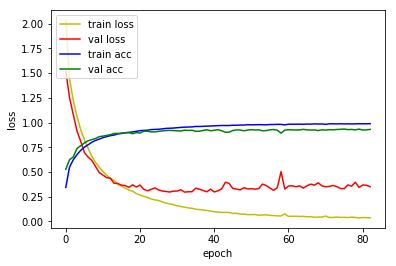

4815/4815 [==============================] - 2s 464us/sample - loss: 0.3787 - acc: 0.8941
Loss: 0.3787354461871946 Accuracy: 0.894081

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0560 - acc: 0.3267
Epoch 00001: val_loss improved from inf to 1.38711, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_7_conv_checkpoint/001-1.3871.hdf5
36805/36805 [==============================] - 36s 985us/sample - loss: 2.0558 - acc: 0.3268 - val_loss: 1.3871 - val_acc: 0.5693
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2973 - acc: 0.5862
Epoch 00002: val_loss improved from 1.38711 to 0.97257, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_7_conv_checkpoint/002-0.9726.hdf5
36805/36805 [==============================] - 33s 910us/sample - loss: 1.2973 - acc: 0.5863 - val_loss: 0.9726 - val_acc: 0.7100
Epoch 3/500
36800/36805 [============================>.] -

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9404
Epoch 00023: val_loss did not improve from 0.19749
36805/36805 [==============================] - 33s 890us/sample - loss: 0.1884 - acc: 0.9404 - val_loss: 0.1994 - val_acc: 0.9439
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9390
Epoch 00024: val_loss did not improve from 0.19749
36805/36805 [==============================] - 33s 893us/sample - loss: 0.1883 - acc: 0.9390 - val_loss: 0.1986 - val_acc: 0.9397
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1743 - acc: 0.9448
Epoch 00025: val_loss improved from 0.19749 to 0.19609, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_7_conv_checkpoint/025-0.1961.hdf5
36805/36805 [==============================] - 33s 889us/sample - loss: 0.1743 - acc: 0.9447 - val_loss: 0.1961 - val_acc: 0.9415
Epoch 26/500
36800/36805 [============================>.] - ET

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9771
Epoch 00050: val_loss did not improve from 0.16902
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0666 - acc: 0.9771 - val_loss: 0.1932 - val_acc: 0.9520
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9778
Epoch 00051: val_loss did not improve from 0.16902
36805/36805 [==============================] - 33s 886us/sample - loss: 0.0649 - acc: 0.9778 - val_loss: 0.1701 - val_acc: 0.9574
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9798
Epoch 00052: val_loss did not improve from 0.16902
36805/36805 [==============================] - 33s 889us/sample - loss: 0.0594 - acc: 0.9798 - val_loss: 0.1778 - val_acc: 0.9562
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9793
Epoch 00053: val_loss did not improve from 0.16902
36805/36805 [=====

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9896
Epoch 00080: val_loss did not improve from 0.16902
36805/36805 [==============================] - 33s 884us/sample - loss: 0.0315 - acc: 0.9895 - val_loss: 0.2119 - val_acc: 0.9525
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9895
Epoch 00081: val_loss did not improve from 0.16902
36805/36805 [==============================] - 32s 883us/sample - loss: 0.0295 - acc: 0.9895 - val_loss: 0.2161 - val_acc: 0.9564
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9908
Epoch 00082: val_loss did not improve from 0.16902
36805/36805 [==============================] - 33s 886us/sample - loss: 0.0275 - acc: 0.9908 - val_loss: 0.2153 - val_acc: 0.9555
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9906
Epoch 00083: val_loss did not improve from 0.16902
36805/36805 [=====

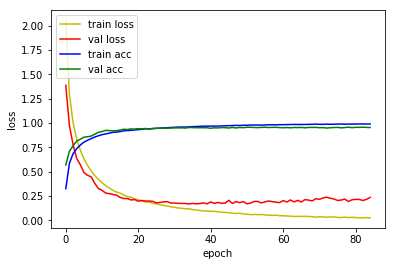

4815/4815 [==============================] - 2s 509us/sample - loss: 0.2445 - acc: 0.9317
Loss: 0.2444613045683036 Accuracy: 0.93167186

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0791 - acc: 0.3160
Epoch 00001: val_loss improved from inf to 1.27871, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_8_conv_checkpoint/001-1.2787.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.0791 - acc: 0.3160 - val_loss: 1.2787 - val_acc: 0.6105
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1976 - acc: 0.6108
Epoch 00002: val_loss improved from 1.27871 to 1.05020, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_8_conv_checkpoint/002-1.0502.hdf5
36805/36805 [==============================] - 34s 921us/sample - loss: 1.1975 - acc: 0.6108 - val_loss: 1.0502 - val_acc: 0.6641
Epoch 3/500
36800/36805 [============================>.] -

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1610 - acc: 0.9463
Epoch 00023: val_loss did not improve from 0.15103
36805/36805 [==============================] - 34s 914us/sample - loss: 0.1610 - acc: 0.9463 - val_loss: 0.1558 - val_acc: 0.9509
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1513 - acc: 0.9512
Epoch 00024: val_loss did not improve from 0.15103
36805/36805 [==============================] - 34s 919us/sample - loss: 0.1513 - acc: 0.9511 - val_loss: 0.1707 - val_acc: 0.9495
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9505
Epoch 00025: val_loss improved from 0.15103 to 0.14289, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_DO_8_conv_checkpoint/025-0.1429.hdf5
36805/36805 [==============================] - 34s 919us/sample - loss: 0.1481 - acc: 0.9505 - val_loss: 0.1429 - val_acc: 0.9539
Epoch 26/500
36800/36805 [============================>.] - ET

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9805
Epoch 00052: val_loss did not improve from 0.13279
36805/36805 [==============================] - 33s 898us/sample - loss: 0.0556 - acc: 0.9805 - val_loss: 0.1433 - val_acc: 0.9618
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9829
Epoch 00053: val_loss did not improve from 0.13279
36805/36805 [==============================] - 33s 894us/sample - loss: 0.0483 - acc: 0.9829 - val_loss: 0.1671 - val_acc: 0.9574
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9832
Epoch 00054: val_loss did not improve from 0.13279
36805/36805 [==============================] - 33s 902us/sample - loss: 0.0481 - acc: 0.9832 - val_loss: 0.1535 - val_acc: 0.9595
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9848
Epoch 00055: val_loss did not improve from 0.13279
36805/36805 [=====


1D_CNN_custom_multi_3_concat_DO_8_conv Model


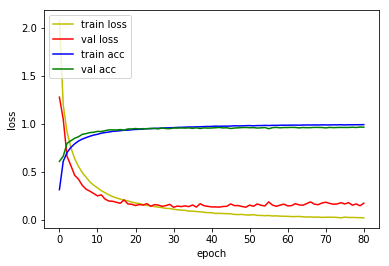

4815/4815 [==============================] - 2s 507us/sample - loss: 0.2161 - acc: 0.9344
Loss: 0.21605762022925562 Accuracy: 0.93437177



In [10]:
base = '1D_CNN_custom_multi_3_concat_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
_______________________________________________________________

4815/4815 [==============================] - 2s 499us/sample - loss: 1.1846 - acc: 0.6318
Loss: 1.1846418001941432 Accuracy: 0.6317757

1D_CNN_custom_multi_3_concat_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPoolin

4815/4815 [==============================] - 3s 528us/sample - loss: 0.3787 - acc: 0.8941
Loss: 0.3787354461871946 Accuracy: 0.894081

1D_CNN_custom_multi_3_concat_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling

4815/4815 [==============================] - 3s 559us/sample - loss: 0.2161 - acc: 0.9344
Loss: 0.21605762022925562 Accuracy: 0.93437177


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
_______________________________________________________________

4815/4815 [==============================] - 3s 537us/sample - loss: 1.8426 - acc: 0.7020
Loss: 1.842565804552809 Accuracy: 0.701973

1D_CNN_custom_multi_3_concat_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1

4815/4815 [==============================] - 3s 574us/sample - loss: 0.4611 - acc: 0.9051
Loss: 0.4610851303346432 Accuracy: 0.90508825

1D_CNN_custom_multi_3_concat_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooli

4815/4815 [==============================] - 3s 602us/sample - loss: 0.2777 - acc: 0.9475
Loss: 0.277709924445709 Accuracy: 0.9474559
